# Vehicle Detection and Tracking
---
> Daniel Stang
    

## Extract Features From Image

### Histogram of Gradient

In [554]:
# Import
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.preprocessing import StandardScaler

print('Import successful.')

Import successful.


In [572]:
# Histogram of Oriented Gradients
def hog_features(img, cspace='gry', chan=0, orientbin=9, cellpix=8, cellb=2, visual=False, vector=True):
    
    # Pick feature and channel to perform HOG on.
    if cspace == 'rgb':
        newimg = img[:,:,chan]
    if cspace == 'gry':
        newimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if cspace == 'hsv':
        tmpimg = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        newimg = tmpimg[:,:,chan]
    if cspace == 'luv':
        tmpimg =  cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        newimg = tmpimg[:,:,chan]
    if cspace == 'hls':
        tmpimg = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        newimg = tmpimg[:,:,chan]
    if cspace == 'yuv':
        tmpimg = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        newimg = tmpimg[:,:,chan]    
    
    if visual == True:
        features, visual_image = hog(newimg, orientations=orientbin,
                                     pixels_per_cell=(cellpix, cellpix),
                                     cells_per_block=(cellb, cellb),
                                     transform_sqrt=True,
                                     visualise=visual, feature_vector=vector)
        return features, visual_image
    else:
        features = hog(newimg, orientations=orientbin,
                       pixels_per_cell=(cellpix, cellpix),
                       cells_per_block=(cellb, cellb),
                       transform_sqrt=True,
                       visualise=visual, feature_vector=vector)
        return features
        
    

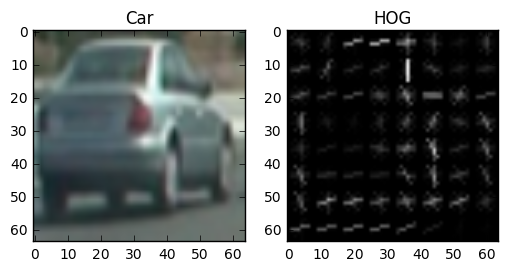

[ 0.03382972  0.00797273  0.01512753 ...,  0.00227814  0.00179451  0.        ]
1764


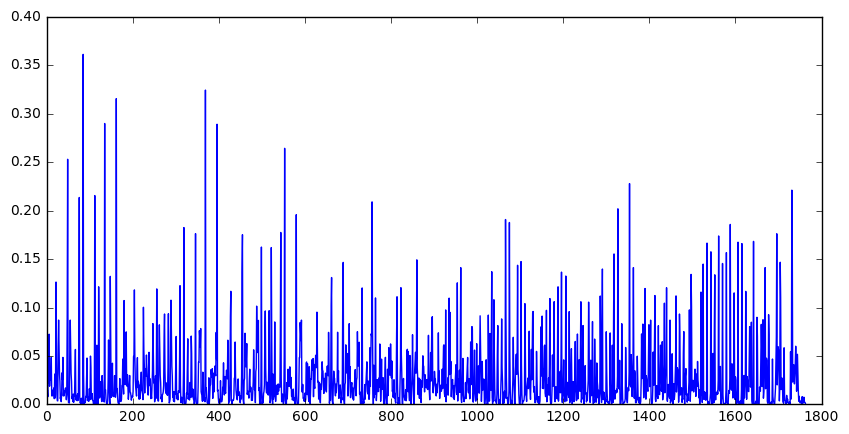

/home/daniel/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/daniel/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


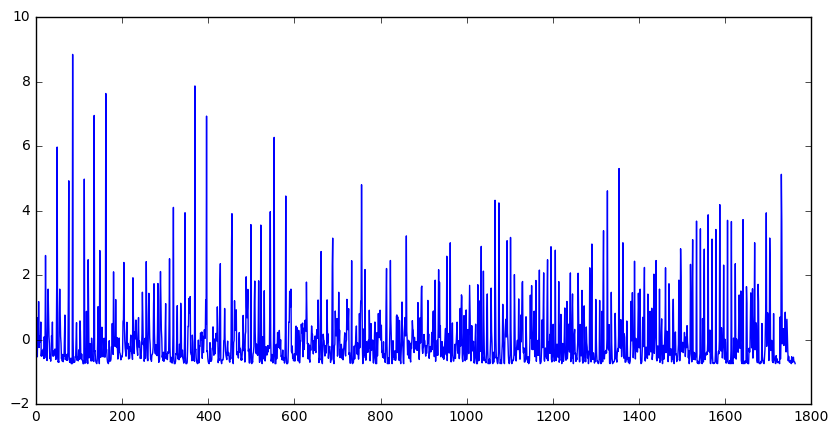

In [561]:
img = mpimg.imread('img/vehicles/GTI_Left/image0010.png')



orientbin = 9
cellpix = 8
cellb = 2

features, visual_image = hog_features(img, 'rgb', 0, orientbin, cellpix, cellb, True)

fig = plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.title('Car')
plt.subplot(122)
plt.imshow(visual_image, cmap='gray')
plt.title('HOG')
plt.show()

print(features)
print(len(features))

fig = plt.figure(figsize=(10,5))
plt.plot(features)
plt.show()

x_scaler = StandardScaler().fit(features)
scaledx = x_scaler.transform(features)

fig = plt.figure(figsize=(10,5))
plt.plot(scaledx)
plt.show()



## Train Classifier

### Label Data


In [482]:
imagename = sorted(glob.glob('img/non-vehicles/Extras/*.png'))
imagename2 = sorted(glob.glob('img/non-vehicles/GTI/*.png'))
imagename = imagename + imagename2
notcarlen = len(imagename)
print(notcarlen)
foldername = sorted(glob.glob('img/vehicles/*'))
for fold in foldername:
    imagename2 = sorted(glob.glob(fold + '/*.png'))
    imagename = imagename + imagename2

print(imagename[notcarlen-1])
print(imagename[notcarlen])
print(len(imagename))


9666
img/non-vehicles/GTI/image999.png
img/vehicles/GTI_Far/image0000.png
18458


In [564]:
# Load all images and extract features.
img = mpimg.imread('img/vehicles/GTI_Left/image0010.png')
testfeat = hog_features(img, 'yuv', 0, orientbin, cellpix, cellb, False)

xdata = np.zeros((18458,len(testfeat))).astype('float32')
i=0
for imgn in tqdm(imagename):
    imgd = mpimg.imread(imgn)
    xdata[i] = hog_features(imgd, 'yuv', 0, orientbin, cellpix, cellb, False)
    i = i + 1

    

100%|██████████| 18458/18458 [00:23<00:00, 800.15it/s]


In [565]:
# Ensure that non vehicles labeled with 0 and vehicles labeled with 1.
y = np.zeros(18458).astype(int)
y[9666:] = 1

print(str(imagename[9665]) + ' ' + str(y[9665]))
print(str(imagename[9666]) + ' ' + str(y[9666]))
print(str(imagename[1337]) + ' ' + str(y[1337]))
print(str(imagename[13337]) + ' ' + str(y[13337]))

img/non-vehicles/GTI/image999.png 0
img/vehicles/GTI_Far/image0000.png 1
img/non-vehicles/Extras/extra2201.png 0
img/vehicles/KITTI_extracted/1760.png 1


In [566]:
X_scaler = StandardScaler().fit(xdata)
scaledx = X_scaler.transform(xdata)

x_train, x_test, y_train, y_test = train_test_split(scaledx, y, test_size=0.2, random_state=1337)

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

14766
14766
3692
3692


### SVC

In [567]:
linsvc = svm.LinearSVC(loss='squared_hinge',tol=1e-4, max_iter=3000)
t = time.time()
linsvc.fit(x_train, y_train)
t2 = time.time()

print('Training time:', t2-t, 'seconds')
print('Train Accuracy', linsvc.score(x_train, y_train))
print('Test Accuracy', linsvc.score(x_test, y_test))


Training time: 16.717409372329712 seconds
Train Accuracy 0.999729107409
Test Accuracy 0.952600216685


    HLS [0, .933], [1, .959], [2, .905]
    HSV [0, .933], [1, .910], [2, .954]
    YUV [0, .963], [1, .947], [2, .xxx]
    RGB [0, .950], [1, .960], [2, .956]

In [433]:
# svc = svm.SVC(kernel='linear')
# t = time.time()
# svc.fit(x_train, y_train)
# t2 = time.time()

# print('Training time:', t2-t, 'seconds')
# print('Train Accuracy', svc.score(x_train, y_train))
# print('Test Accuracy', svc.score(x_test, y_test))


# Stats using rbf kernel.
# 1.9 seconds to fit 922 samples.
# 121 seconds to fit 9229 samples.
# Takes waaaay to long when using rbf on so many samples
# and linear SVC seems to do just fine accuracy wise.

### Decision Tree

In [434]:
dtree = tree.DecisionTreeClassifier(min_samples_split=20, max_depth=8)
t = time.time()
dtree = dtree.fit(x_train, y_train)
t2 = time.time()

print('Training time:', t2-t, 'seconds')
print('Train Accuracy', dtree.score(x_train, y_train))
print('Test Accuracy', dtree.score(x_test, y_test))
    

Training time: 21.253904342651367 seconds
Train Accuracy 0.940877691995
Test Accuracy 0.866738894908


## Sliding Window Search


150


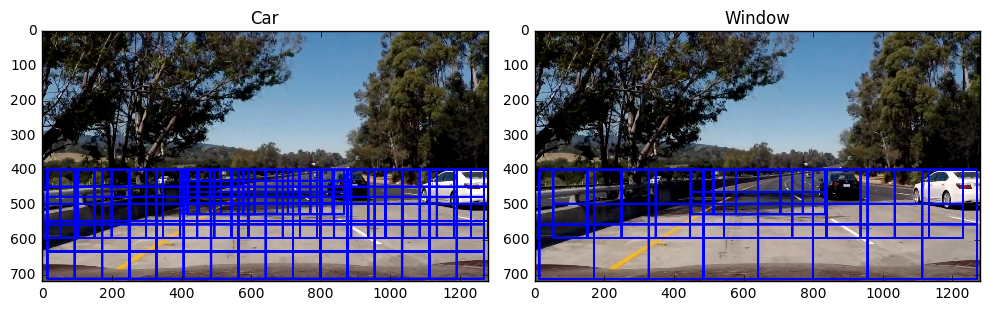

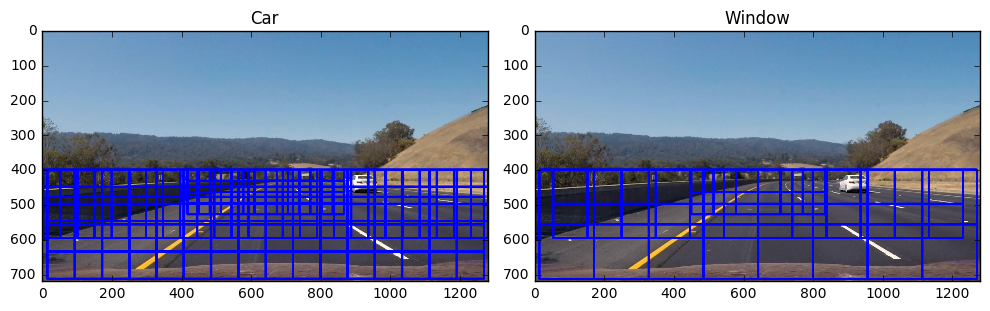

In [435]:
# Draw boxes on new image.
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

# Crop window area of image 
def crop_resize(img, window):
    
    crop = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    
    resize = cv2.resize(crop, (64, 64))
    
    return resize

# Return x and y coordinates for all computed window search positions.
def slide_window(img, xy_overlap = 0.5, xy_window = 64, y_start_stop=[400, None]):
    
    
    xcenter = np.int(img.shape[1]/2)
    
    # If y start/stop positions not defined, set to image size.    
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Initialize a list to append window positions to.
    window_list = []

    
    starty = y_start_stop[0]
    ny_window = 3
    growth = 1.104
    
    for yi in range(0,ny_window):
        step = np.int(xy_window *(1 - xy_overlap))
        endy = starty + xy_window
        nx_window = np.int(img.shape[1]/(step*2))
        if yi == 0:
            nx_window = nx_window - 7*np.int(xy_window/step)
            # How many xy_window tall pixels should be covered in the y direction.
            ystack = 2
        if yi == 1:
            nx_window = nx_window - 0*np.int(xy_window/step)
            ystack = 2
        if yi == 2:
            ystack = 2
            nx_window = nx_window - 0*np.int(xy_window/step)
        
        # Ensures that both overlap and non-overlap cases cover the same number of pixels
        # in the y direction. Ex smallest boxes want to cover 2 * 64 pixels. With non-overlap
        # thats two sets of 64 pixel tall windows stacked on top of eachother. For 50% overlap 
        # that requires 3 sets of 64 pixels tall windows with 50% overlap.
        if xy_overlap != 0:
            ystack =  np.int(ystack*(xy_window/step)) - 1
            
        for yii in range(ystack):
            for xi in range(nx_window):
                startx = xcenter + xi*step
                endx = startx + xy_window
                # Only add to list if within image bounds.
                if endx < img.shape[1]:
                    window_list.append( ((startx, starty), (endx, endy)) )

                endx = xcenter - xi*step
                startx = endx - xy_window
                # Only add to list if within image bounds.
                if startx > 0:
                    window_list.append( ((startx, starty), (endx, endy)) )
            
            starty = starty + step
            endy = starty + xy_window
            
        starty = y_start_stop[0]
        xy_window = np.int(xy_window **growth)
        
        
    
    # Return the list of window positions.
    return window_list

debug_img()

/home/daniel/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


[[ 640  400  704  464]
 [ 576  400  640  464]
 [ 672  400  736  464]
 [ 544  400  608  464]
 [ 704  400  768  464]
 [ 512  400  576  464]
 [ 736  400  800  464]
 [ 480  400  544  464]
 [ 768  400  832  464]
 [ 448  400  512  464]
 [ 800  400  864  464]
 [ 416  400  480  464]
 [ 640  432  704  496]
 [ 576  432  640  496]
 [ 672  432  736  496]
 [ 544  432  608  496]
 [ 704  432  768  496]
 [ 512  432  576  496]
 [ 736  432  800  496]
 [ 480  432  544  496]
 [ 768  432  832  496]
 [ 448  432  512  496]
 [ 800  432  864  496]
 [ 416  432  480  496]
 [ 640  464  704  528]
 [ 576  464  640  528]
 [ 672  464  736  528]
 [ 544  464  608  528]
 [ 704  464  768  528]
 [ 512  464  576  528]
 [ 736  464  800  528]
 [ 480  464  544  528]
 [ 768  464  832  528]
 [ 448  464  512  528]
 [ 800  464  864  528]
 [ 416  464  480  528]
 [ 640  400  738  498]
 [ 542  400  640  498]
 [ 689  400  787  498]
 [ 493  400  591  498]
 [ 738  400  836  498]
 [ 444  400  542  498]
 [ 787  400  885  498]
 [ 395  400

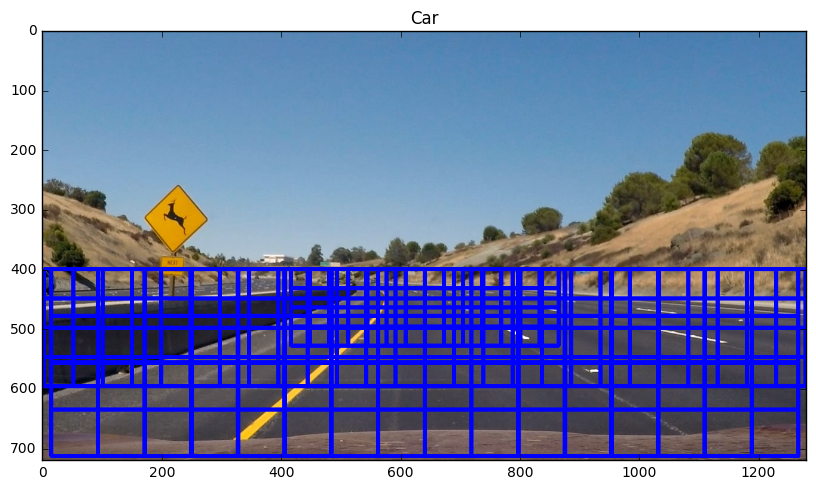

In [573]:
img = mpimg.imread('CarND-Vehicle-Detection/test_images/test2.jpg')
windows = slide_window(img,0.5)

b = None
for i in range(len(windows)):
    newimg = crop_resize(img, windows[i])
    a = linsvc.predict(hog_features(newimg, 'yuv', 0).reshape(1, -1))
    if a == 1:
        if b == None:
            temp = np.hstack(windows[i])
            b = temp
            img = draw_boxes(img, windows[i:i+1])
        else:
            temp = np.hstack(windows[i])
            img = draw_boxes(img, windows[i:i+1])
            b = np.vstack((b, temp)).astype(int)

print(b)



fig = plt.figure(figsize=(10,5))
plt.imshow(img)
plt.title('Car')
plt.tight_layout()
plt.show()

In [437]:
def debug_img():
    img = mpimg.imread('CarND-Vehicle-Detection/test_images/test5.jpg')
    windows = slide_window(img,0.5)
    imgbox = draw_boxes(img, windows)
    print(len(windows))
        
    fig = plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(imgbox)
    plt.title('Car')

    windows = slide_window(img, 0)
    imgbox = draw_boxes(img, windows)

    plt.subplot(122)
    plt.imshow(imgbox)
    plt.title('Window')
    plt.tight_layout()
    plt.show()

    img = mpimg.imread('CarND-Vehicle-Detection/test_images/test3.jpg')
    windows = slide_window(img,0.5)
    imgbox = draw_boxes(img, windows)

    fig = plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(imgbox)
    plt.title('Car')

    windows = slide_window(img, 0)
    imgbox = draw_boxes(img, windows)

    plt.subplot(122)
    plt.imshow(imgbox)
    plt.title('Window')
    plt.tight_layout()
    plt.show()